<a href="https://colab.research.google.com/github/Akash276/AI-Solutions/blob/master/Seller_Side_Marketplace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
sns.set_style('whitegrid', {'grid.linestyle': '--'})

%matplotlib inline

In [6]:
pip install pandas --upgrade

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.5)


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
# Load 'MQL' dataset
mql = pd.read_csv('/content/gdrive/My Drive/Intern_ML/Data_Sets/Q_2/olist_marketing_qualified_leads_dataset.csv',
                  parse_dates=['first_contact_date'])

print(mql.shape)
mql.head(3)


(8000, 4)


,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search


In [9]:
# Add a 'year-month' column
mql['first_contact_date(y-m)'] = mql['first_contact_date'].dt.to_period('M')

print(mql.shape)
mql[['first_contact_date', 'first_contact_date(y-m)']].head(3)

(8000, 5)


,first_contact_date,first_contact_date(y-m)
0,2018-02-01,2018-02
1,2017-10-20,2017-10
2,2018-03-22,2018-03


In [10]:
# Create time series table
monthly_mql = mql.groupby(by='first_contact_date(y-m)').mql_id \
                                                       .count()
monthly_mql.to_frame().T

first_contact_date(y-m),2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
mql_id,4,239,386,312,416,445,200,1141,1028,1174,1352,1303


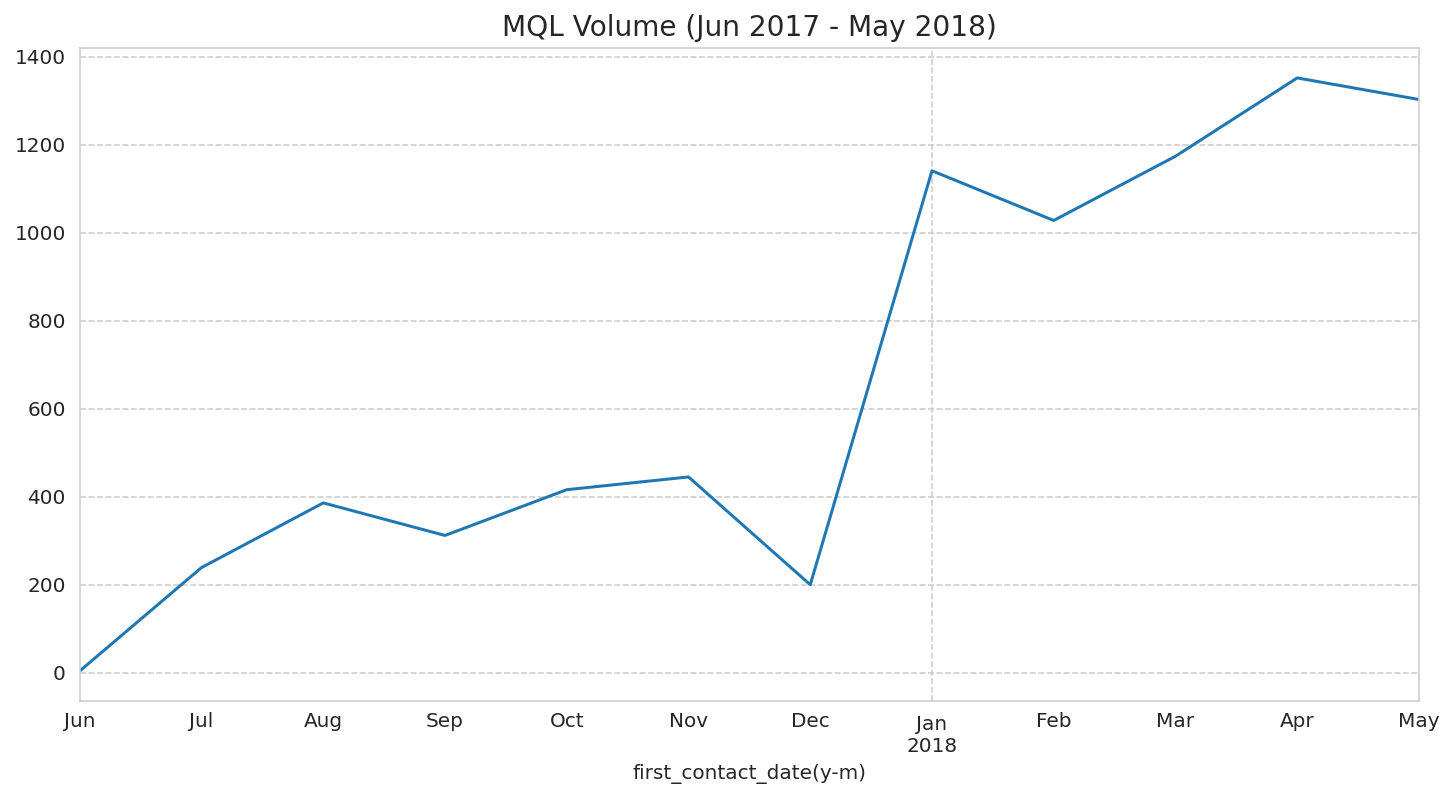

In [11]:
# Plot the monthly MQL volume
monthly_mql.plot.line(figsize=(12, 6))
plt.title('MQL Volume (Jun 2017 - May 2018)', fontsize=14);

In [12]:
# Create 'channel-time series' table
mql_origin = pd.pivot_table(mql,
                            index='origin',
                            columns='first_contact_date(y-m)',
                            values='mql_id',                            
                            aggfunc='count',
                            fill_value=0)

# Sort index from largest to smallest in volume
origin_list = mql.groupby('origin').mql_id \
                                   .count() \
                                   .sort_values(ascending=False) \
                                   .index

mql_origin = mql_origin.reindex(origin_list)
mql_origin

first_contact_date(y-m),2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
origin,,,,,,,,,,,,
organic_search,0,54,122,78,125,121,60,412,291,340,349,344
paid_search,0,56,79,64,100,70,35,170,212,262,272,266
social,0,12,45,56,52,95,39,162,156,139,325,269
unknown,1,35,70,39,53,63,25,151,156,186,166,154
direct_traffic,0,16,22,22,23,26,10,82,65,80,75,78
email,1,19,24,23,30,37,12,61,68,74,50,94
referral,0,8,16,12,8,20,9,41,34,38,45,53
other,0,12,3,9,8,3,1,39,16,22,26,11
display,1,19,2,5,5,6,5,11,18,16,19,11


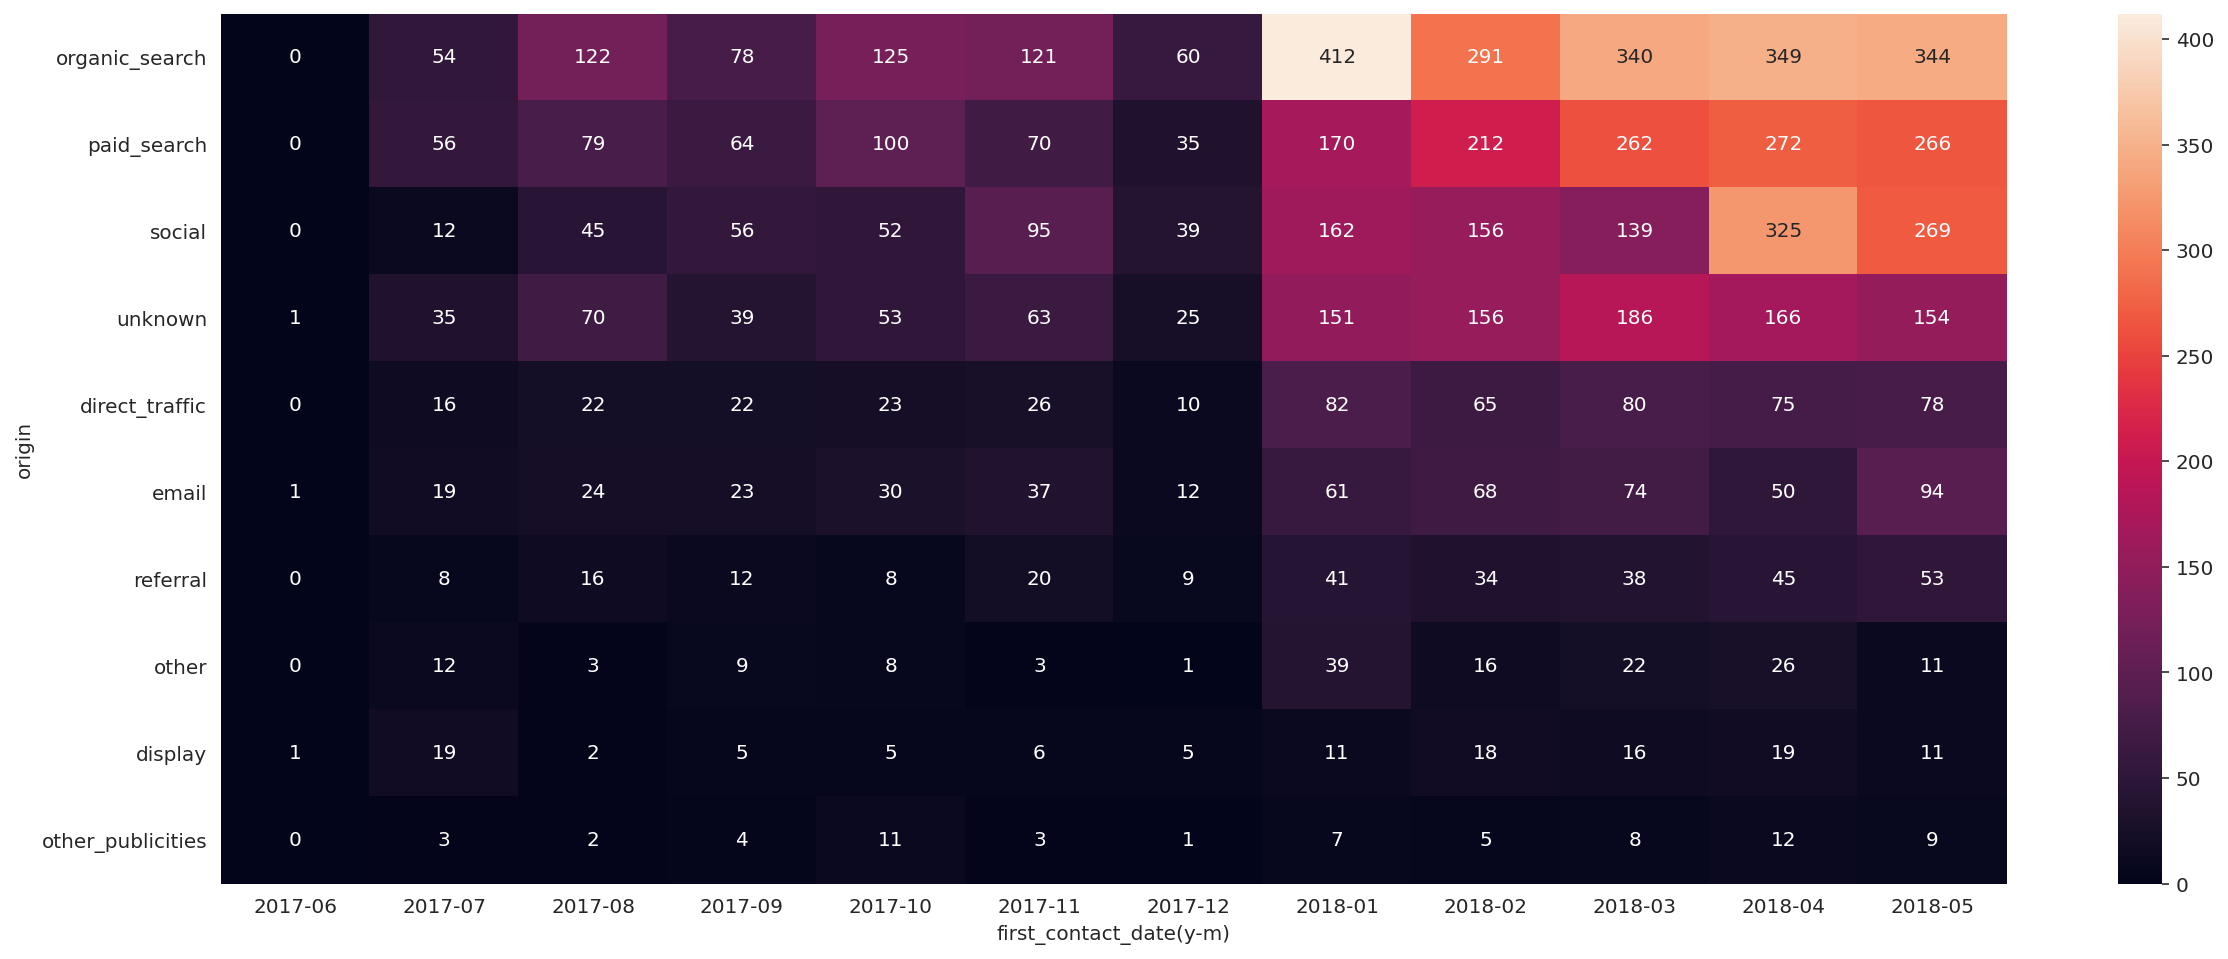

In [13]:
# Plot the monthly volume by channel
plt.figure(figsize=(20,8))
sns.heatmap(mql_origin, annot=True, fmt='g');

In [14]:
# Load 'closed deals' dataset
cd = pd.read_csv('/content/gdrive/My Drive/Intern_ML/Data_Sets/Q_2/olist_closed_deals_dataset.csv',
                 parse_dates=['won_date'])

print(cd.shape)
cd.head(3)

(842, 14)


,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0


In [15]:
# Merge 'MQL' with 'closed deals'
# Merge by 'left' in order to evaluate conversion rate
mql_cd = pd.merge(mql,
                  cd,
                  how='left',
                  on='mql_id')

print(mql_cd.shape)
mql_cd.head(3)

(8000, 18)


,mql_id,first_contact_date,landing_page_id,origin,first_contact_date(y-m),seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,2018-02,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,2017-10,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,2018-03,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Add a column to distinguish signed MOLs from MQLs who left without signing up
mql_cd['seller_id(bool)'] = mql_cd['seller_id'].notna()

print(mql_cd.shape)
mql_cd[['seller_id', 'seller_id(bool)']].head()

(8000, 19)


,seller_id,seller_id(bool)
0,NaN,False
1,NaN,False
2,NaN,False
3,NaN,False
4,2c43fb513632d29b3b58df74816f1b06,True


In [17]:
# Compute monthly closed deals
monthly_cd = mql_cd.groupby('first_contact_date(y-m)')['seller_id(bool)'].sum()
monthly_cd.to_frame().T

first_contact_date(y-m),2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
seller_id(bool),0.0,2.0,9.0,7.0,14.0,18.0,11.0,152.0,149.0,167.0,183.0,130.0


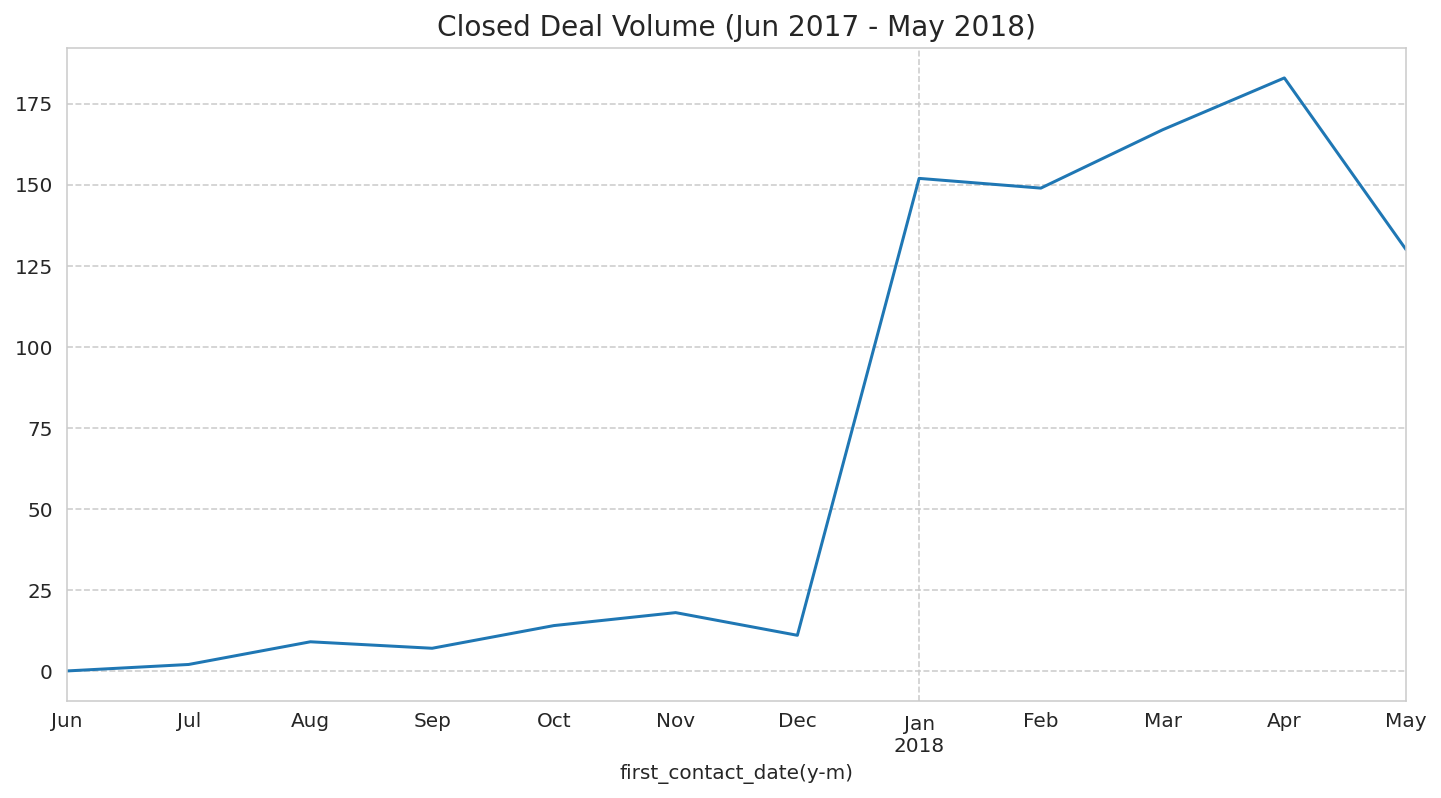

In [18]:
# Plot the monthly volume of closed deals
monthly_cd.plot.line(figsize=(12, 6))
plt.title('Closed Deal Volume (Jun 2017 - May 2018)', fontsize=14);

In [19]:
# Calculate monthly conversion rate
monthly_conversion = mql_cd.groupby(by='first_contact_date(y-m)')['seller_id(bool)'].agg(['count', 'sum'])

monthly_conversion['conversion_rate(%)'] = ((monthly_conversion['sum'] / monthly_conversion['count']) * 100).round(1)
monthly_conversion.T

first_contact_date(y-m),2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
count,4.0,239.0,386.0,312.0,416.0,445.0,200.0,1141.0,1028.0,1174.0,1352.0,1303.0
sum,0.0,2.0,9.0,7.0,14.0,18.0,11.0,152.0,149.0,167.0,183.0,130.0
conversion_rate(%),0.0,0.8,2.3,2.2,3.4,4.0,5.5,13.3,14.5,14.2,13.5,10.0


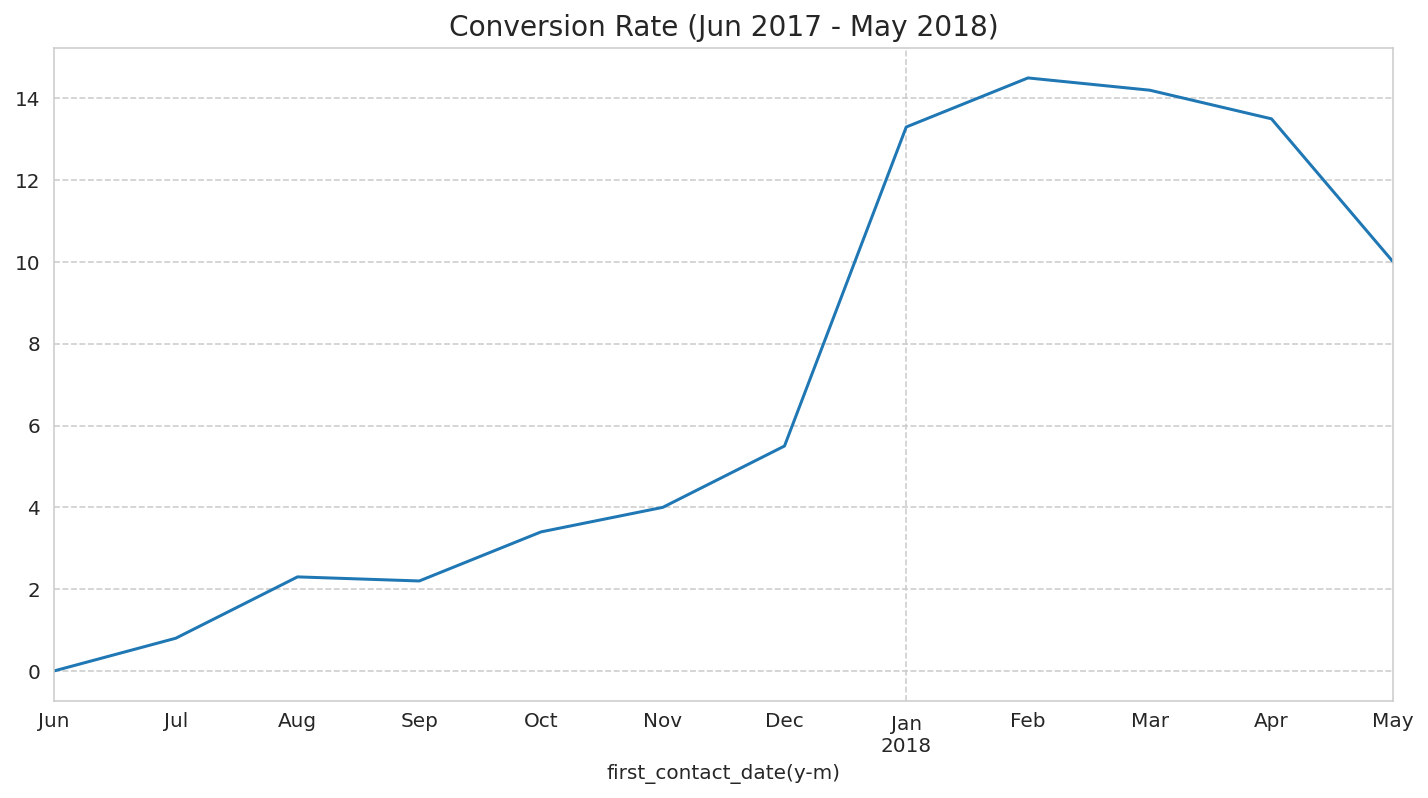

In [20]:
# Plot the monthly conversion rate
monthly_conversion['conversion_rate(%)'].plot.line(figsize=(12, 6))
plt.title('Conversion Rate (Jun 2017 - May 2018)', fontsize=14);

In [21]:
# Calculate sales length in days
mql_cd['sales_length(day)'] = np.ceil((mql_cd['won_date'] - mql_cd['first_contact_date'])
                                      .dt.total_seconds()
                                      / (60*60*24))

print(mql_cd.shape)
mql_cd[['first_contact_date', 'won_date', 'sales_length(day)']].head()

(8000, 20)


,first_contact_date,won_date,sales_length(day)
0,2018-02-01,NaT,NaN
1,2017-10-20,NaT,NaN
2,2018-03-22,NaT,NaN
3,2018-01-22,NaT,NaN
4,2018-02-21,2018-02-26 19:58:54,6.0


In [22]:
# Separate sales length for each year
closed_deal = (mql_cd['seller_id'].notna())
lead_2017 = (mql_cd['first_contact_date'].dt.year.astype('str') == '2017')
lead_2018 = (mql_cd['first_contact_date'].dt.year.astype('str') == '2018')

sales_length_2017 = mql_cd[closed_deal & lead_2017]['sales_length(day)']
sales_length_2018 = mql_cd[closed_deal & lead_2018]['sales_length(day)']

sales_length_2017.head(3), sales_length_2018.head(3)

(67     268.0
 110    189.0
 239     55.0
 Name: sales_length(day), dtype: float64, 4      6.0
 12    35.0
 14    64.0
 Name: sales_length(day), dtype: float64)

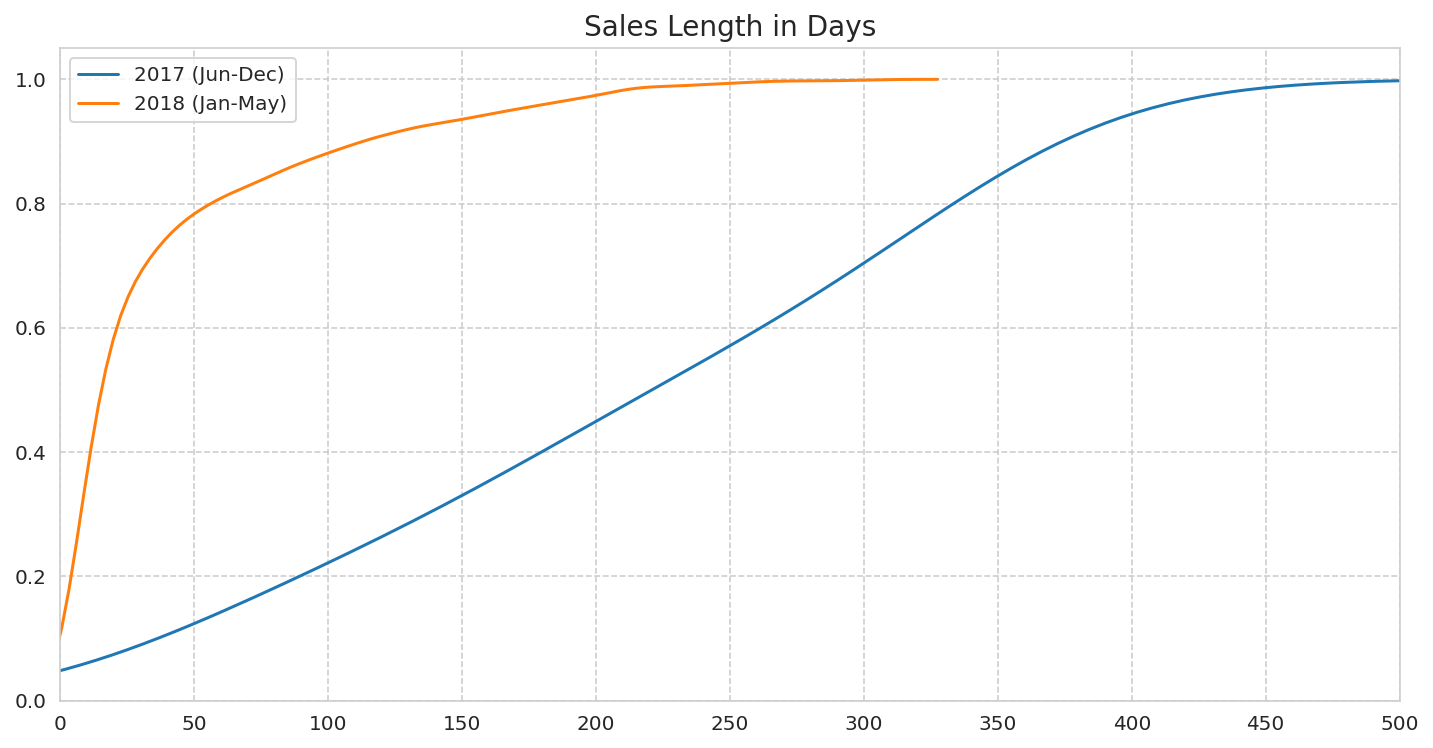

In [23]:
# Plot the sales length of each year
figure, ax = plt.subplots(figsize=(12,6))

sns.kdeplot(sales_length_2017,
            cumulative=True,
            label='2017 (Jun-Dec)',
            ax=ax)
sns.kdeplot(sales_length_2018,
            cumulative=True,
            label='2018 (Jan-May)',
            ax=ax)

ax.set_title('Sales Length in Days', fontsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xlim(0,500);

In [24]:
# Bring 'closed deals' data
cd_profile = cd[cd['lead_behaviour_profile'].notna()].copy()

print(cd_profile.shape)
cd_profile['lead_behaviour_profile'].value_counts()

(665, 14)


cat            407
eagle          123
wolf            95
shark           24
cat, wolf        8
eagle, wolf      3
eagle, cat       3
shark, wolf      1
shark, cat       1
Name: lead_behaviour_profile, dtype: int64

In [25]:
# Combine four types of mixed profiles(2.4%) into 'others'
profile_list = ['cat', 'eagle', 'wolf', 'shark']

cd_profile['lead_behaviour_profile(upd)'] = cd_profile.lead_behaviour_profile \
                                                      .map(lambda profile: profile
                                                           if profile in profile_list
                                                           else 'others')

print(cd_profile.shape)
cd_profile['lead_behaviour_profile(upd)'].value_counts()

(665, 15)


cat       407
eagle     123
wolf       95
shark      24
others     16
Name: lead_behaviour_profile(upd), dtype: int64

In [26]:
# Create 'profile - lead type' table
cols = cd_profile['lead_type'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_leadType = pd.pivot_table(cd_profile,
                                  index='lead_behaviour_profile(upd)',
                                  columns='lead_type',
                                  values='seller_id',
                                  aggfunc='count',
                                  fill_value=0)

profile_leadType = profile_leadType.reindex(index)[cols]
profile_leadType

lead_type,online_medium,online_big,industry,offline,online_small,online_beginner,online_top,other
cat,157,72,49,49,37,31,8,2
eagle,46,11,25,22,12,6,1,0
wolf,45,16,14,9,6,5,0,0
shark,9,4,4,5,1,0,1,0
others,8,3,2,1,1,0,0,1


In [27]:
# Create 'profile - business type' table
cols = cd_profile['business_type'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_businessType = pd.pivot_table(cd_profile,
                                      index='lead_behaviour_profile(upd)',
                                      columns='business_type',
                                      values='seller_id',
                                      aggfunc='count',
                                      fill_value=0)

profile_businessType = profile_businessType.reindex(index)[cols]
profile_businessType

business_type,reseller,manufacturer,other
cat,284,116,2
eagle,83,37,0
wolf,69,26,0
shark,16,7,0
others,13,2,1


In [28]:
# Create 'profile - business segment' table
cols = cd_profile['business_segment'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_segment = pd.pivot_table(cd_profile,
                                 index='lead_behaviour_profile(upd)',
                                 columns='business_segment',
                                 values='seller_id',
                                 aggfunc='count',
                                 fill_value=0)

profile_segment = profile_segment.reindex(index)[cols]
profile_segment

business_segment,home_decor,health_beauty,car_accessories,construction_tools_house_garden,household_utilities,audio_video_electronics,computers,pet,sports_leisure,food_supplement,bags_backpacks,food_drink,toys,bed_bath_table,fashion_accessories,handcrafted,stationery,phone_mobile,home_office_furniture,small_appliances,baby,home_appliances,watches,music_instruments,books,gifts,jewerly,other,party,perfume,air_conditioning,games_consoles,religious
cat,51,43,41,35,32,38,16,15,17,13,9,8,9,11,8,7,8,6,6,6,6,3,2,2,2,3,3,2,2,1,0,1,1
eagle,11,13,12,11,12,8,3,4,4,5,4,4,3,2,4,3,1,4,4,1,2,1,2,2,0,1,0,0,1,1,0,0,0
wolf,14,8,9,7,9,8,5,4,1,2,4,4,1,2,1,1,1,0,1,1,1,2,1,2,4,0,1,0,0,0,1,0,0
shark,4,5,2,4,3,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
others,0,1,2,0,1,0,2,0,0,0,0,1,2,1,0,0,1,0,0,2,0,0,1,0,0,0,0,1,0,0,0,1,0


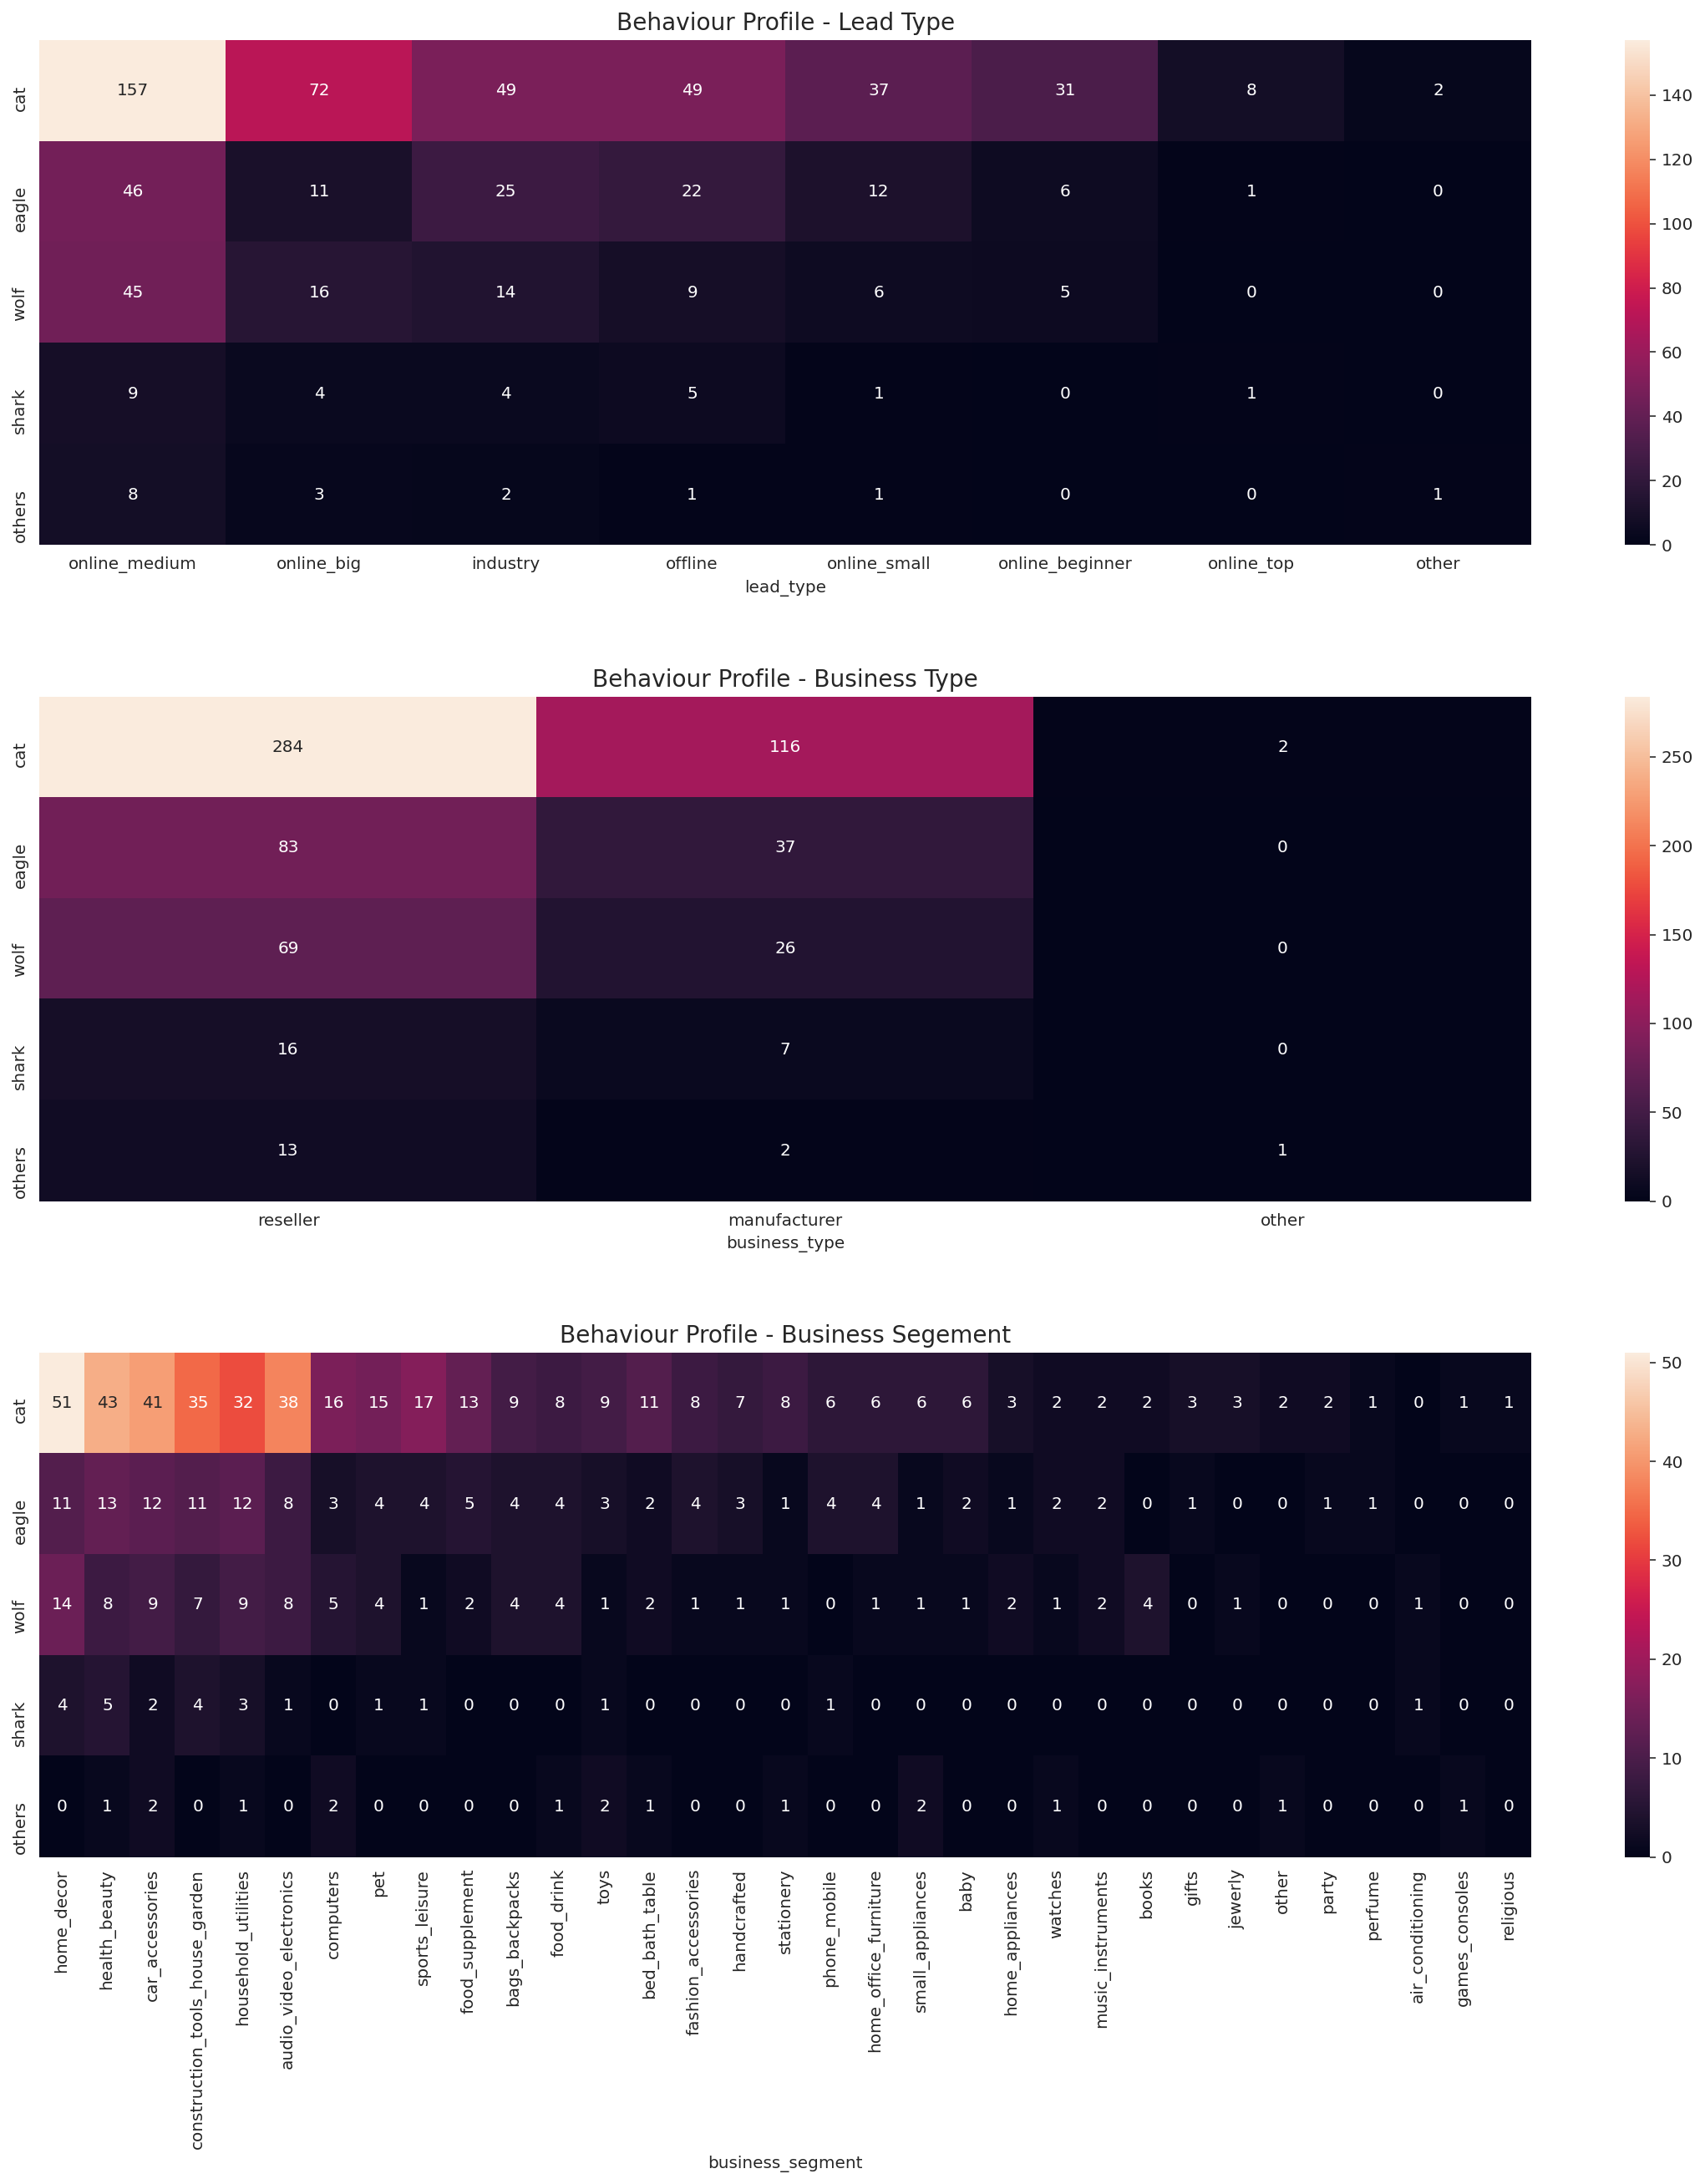

In [29]:
# Plot the above three tables
figure, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,20))
figure.subplots_adjust(hspace=0.3)

sns.heatmap(profile_leadType,
            annot=True,
            fmt='g',
            ax=ax1)
sns.heatmap(profile_businessType,
            annot=True,
            fmt='g',
            ax=ax2)
sns.heatmap(profile_segment,
            annot=True,
            fmt='g',
            ax=ax3)

ax1.set_title('Behaviour Profile - Lead Type', fontsize=14)
ax2.set_title('Behaviour Profile - Business Type', fontsize=14)
ax3.set_title('Behaviour Profile - Business Segement', fontsize=14);

In [30]:
# Create 'profile-SDR' table
cols = cd_profile['sdr_id'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_sdr = pd.pivot_table(cd_profile,
                             index='lead_behaviour_profile(upd)',
                             columns='sdr_id',
                             values='seller_id',
                             aggfunc='count',
                             fill_value=0)

profile_sdr = profile_sdr.reindex(index)[cols] # Sort SDR in descending order of volume 
profile_sdr

sdr_id,4b339f9567d060bcea4f5136b9f5949e,9d12ef1a7eca3ec58c545c678af7869c,a8387c01a09e99ce014107505b92388c,9e4d1098a3b0f5da39b0bc48f9876645,068066e24f0c643eb1d089c7dd20cd73,370c9f455f93a9a96cbe9bea48e70033,09285259593c61296eef10c734121d5b,f42a2bd194f7802ab052a815c8de65b7,34d40cdaf94010a1d05b0d6212f9e909,56bf83c4bb35763a51c2baab501b4c67,b90f87164b5f8c2cfa5c8572834dbe3f,0a0fb2b07d841f84fb6714e35c723075,de63de0d10a6012430098db33c679b0b,e7dff61b78bebffa71678e126ce669ad,45749fb708130f78d0db07d8d80f030b,fdb16d3cbbeb5798f2f66c4096be026d,9749123c950bf8363ace42cb1c2d0815,33dd30594303eb0ebe12a556d612c437,2b63542749aa9caf15f21816da1db341,323cff2ceea1814239bc2c7e614d260d,0cdad77786224a7cefea567b8c75c3c1,b34f6eba10f46bf9a657a01c108a8284,6aa3b86a83d784b05f0e37e26b20860d,b1b3ec93fc27a19fdb1c1b1fc997776a,282f16e20d50cb18d05182e80f6b9dd6,084b6fbb10729ed4da8c3d3f5a3ae7c9,5b7ce8c2b0fe4c2f52a0763046914ef4,e4a6222cdb5b34375400904f03d8e6a5,19f3cd308f1455b3fa09a282e0d496f4
cat,52,35,50,37,43,26,25,23,30,24,15,10,8,4,3,5,3,3,2,2,2,1,1,0,0,1,1,0,1
eagle,9,22,4,10,3,14,8,7,8,16,4,12,2,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
wolf,42,6,3,3,3,7,7,7,1,0,3,1,2,2,3,1,1,0,1,1,0,0,0,0,1,0,0,0,0
shark,8,0,0,3,2,2,2,1,2,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
others,1,1,0,0,0,1,0,4,0,0,2,0,0,2,2,0,1,0,0,0,0,0,0,1,0,0,0,1,0


In [31]:
# Create 'profile-SR' table
cols = cd_profile['sr_id'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_sr = pd.pivot_table(cd_profile,
                            index='lead_behaviour_profile(upd)',
                            columns='sr_id',
                            values='seller_id',
                            aggfunc='count',
                            fill_value=0)

profile_sr = profile_sr.reindex(index)[cols] # Sort SR in descending order of volume
profile_sr

sr_id,4ef15afb4b2723d8f3d81e51ec7afefe,85fc447d336637ba1df43e793199fbc8,6565aa9ce3178a5caf6171827af3a9ba,d3d1e91a157ea7f90548eef82f1955e3,de63de0d10a6012430098db33c679b0b,2695de1affa7750089c0455f8ce27021,495d4e95a8cf8bbf8b432b612a2aa328,fbf4aef3f6915dc0c3c97d6812522f6a,c638112b43f1d1b86dcabb0da720c901,068066e24f0c643eb1d089c7dd20cd73,a8387c01a09e99ce014107505b92388c,9e4d1098a3b0f5da39b0bc48f9876645,060c0a26f19f4d66b42e0d8796688490,56bf83c4bb35763a51c2baab501b4c67,9ae085775a198122c5586fa830ff7f2b,34d40cdaf94010a1d05b0d6212f9e909,4b339f9567d060bcea4f5136b9f5949e,9749123c950bf8363ace42cb1c2d0815,9d12ef1a7eca3ec58c545c678af7869c,0a0fb2b07d841f84fb6714e35c723075,6aa3b86a83d784b05f0e37e26b20860d,b90f87164b5f8c2cfa5c8572834dbe3f
cat,58,41,31,28,37,34,30,30,17,11,14,16,15,17,12,3,7,2,3,1,0,0
eagle,23,7,13,12,7,9,6,9,5,7,6,6,2,2,4,4,0,0,0,0,0,1
wolf,12,11,11,11,5,6,7,2,3,4,3,0,6,2,5,0,2,4,1,0,0,0
shark,0,4,0,2,4,2,2,2,0,1,0,2,1,2,1,0,0,1,0,0,0,0
others,2,0,0,1,0,2,1,0,0,2,1,0,0,0,1,3,0,0,2,0,1,0


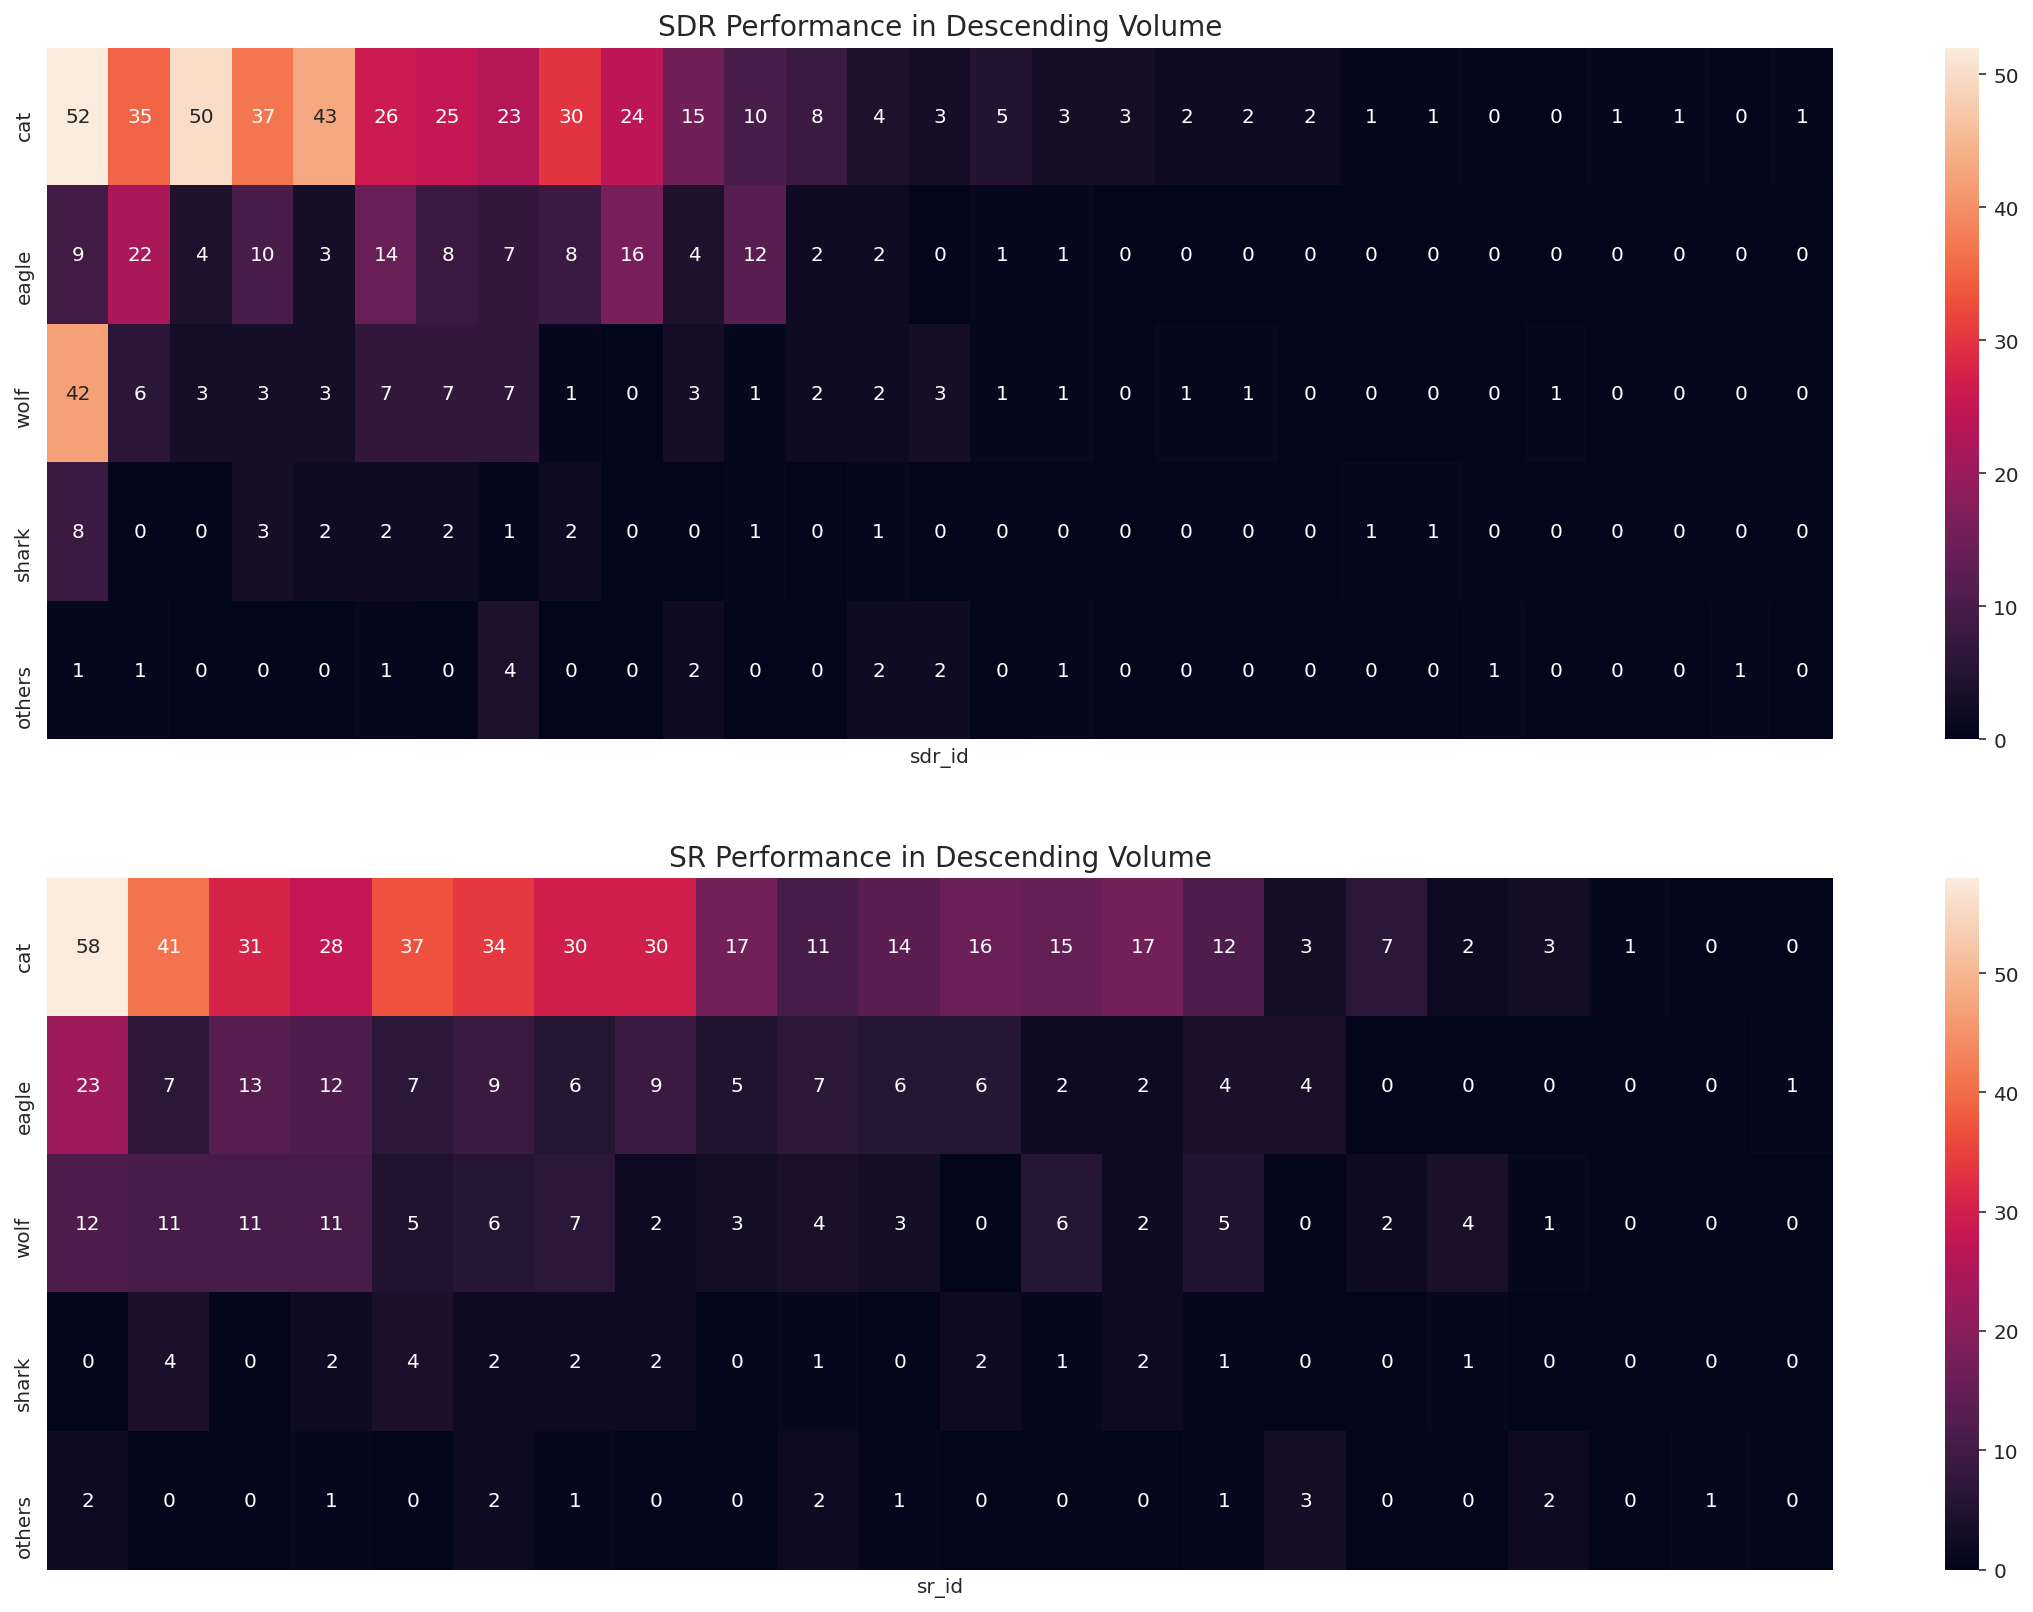

In [32]:
# Plot the two tables
figure, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,14))
figure.subplots_adjust(hspace=0.2)

sns.heatmap(profile_sdr,
            annot=True,
            fmt='g',
            ax=ax1)
sns.heatmap(profile_sr,
            annot=True,
            fmt='g',
            ax=ax2)

ax1.set_title('SDR Performance in Descending Volume', fontsize=14)
ax2.set_title('SR Performance in Descending Volume', fontsize=14)
ax1.set_xticks([])
ax2.set_xticks([]);

In [33]:
# Load datasets
cd = pd.read_csv('/content/gdrive/My Drive/Intern_ML/Data_Sets/Q_2/olist_closed_deals_dataset.csv')
order_items = pd.read_csv('/content/gdrive/My Drive/Intern_ML/Data_Sets/Q_2/olist_order_items_dataset.csv')
orders = pd.read_csv('/content/gdrive/My Drive/Intern_ML/Data_Sets/Q_2/olist_orders_dataset.csv',
                     parse_dates=['order_purchase_timestamp'])
products = pd.read_csv('/content/gdrive/My Drive/Intern_ML/Data_Sets/Q_2/olist_products_dataset.csv')
product_translation = pd.read_csv('/content/gdrive/My Drive/Intern_ML/Data_Sets/Q_2/product_category_name_translation.csv')

In [34]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14


In [35]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [36]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [37]:
product_translation.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [38]:
print(cd.shape)
print(order_items.shape)
print(orders.shape)
print(products.shape)
print(product_translation.shape)

(842, 14)
(112650, 6)
(99441, 8)
(32951, 9)
(71, 2)


In [39]:
# Merge all of the data
data = pd.merge(cd,order_items,
                how='inner', on='seller_id')
data = pd.merge(data, orders,
                how='inner', on='order_id')
data = pd.merge(data, products,
                how='inner', on='product_id')
data = pd.merge(data, product_translation,
                how='left', on='product_category_name') # There are some data without english names
data.shape

(5044, 35)

In [40]:
# Sort out orders not devliered to customers
data = data[data['order_status'] == 'delivered']

# Add a 'year-month' column
data['order_purchase_timestamp(y-m)'] = data['order_purchase_timestamp'].dt.to_period('M')

print(data.shape)
data

(4984, 36)


,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_purchase_timestamp(y-m)
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,1efcc6ba75b519535a510c53153a9256,1,e94df75b2e9a8b056be0c144a731f55c,94.2,18.76,27a878219114302047d41366ffeeba1e,delivered,2018-06-20 21:40:18,2018-06-20 22:20:21,2018-06-22 15:23:00,2018-06-26 20:06:25,2018-07-17 00:00:00,pet_shop,56.0,1538.0,2.0,625.0,23.0,17.0,19.0,pet_shop,2018-06
1,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,d8d281c1a1398a1e835fdc4adfb81e2a,1,9e0873e9ac04b12f282b81af5daebd2e,664.0,38.41,14c1e4101ca2dc7dbf876d9c9e6b11a6,delivered,2018-07-23 20:50:50,2018-07-24 10:31:11,2018-07-25 15:09:00,2018-07-27 18:27:42,2018-08-07 00:00:00,ferramentas_jardim,25.0,432.0,1.0,2825.0,29.0,29.0,29.0,garden_tools,2018-07
2,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,e5858127da61f07285827883e605254b,1,9bb2d066e4b33b624cbdfec7d50b3dcb,99.8,15.00,bcd15e6f5399f2899de4482cf6783dae,delivered,2018-06-21 15:42:55,2018-06-21 16:00:04,2018-06-22 15:23:00,2018-06-25 14:28:27,2018-07-13 00:00:00,pet_shop,53.0,1494.0,2.0,900.0,26.0,19.0,23.0,pet_shop,2018-06
3,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,0475d054d40280dfba750663c9ad7a0a,1,a86859b91d632c991b914aead6ec8ad4,49.9,13.69,5c232e92346113f68998cf6395eb457f,delivered,2018-07-24 17:25:33,2018-07-24 17:35:18,2018-07-31 14:18:00,2018-08-03 18:41:28,2018-08-17 00:00:00,sinalizacao_e_seguranca,60.0,1170.0,1.0,450.0,16.0,5.0,16.0,signaling_and_security,2018-07
4,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,e987b29cdd5c19069d7c65a4eac2a806,1,a86859b91d632c991b914aead6ec8ad4,49.9,22.28,a5772880d8e7c4d0b5a1819180bb39a6,delivered,2018-07-15 21:52:17,2018-07-15 22:04:16,2018-07-16 14:19:00,2018-07-31 19:02:38,2018-08-08 00:00:00,sinalizacao_e_seguranca,60.0,1170.0,1.0,450.0,16.0,5.0,16.0,signaling_and_security,2018-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5039,676207ddcc8087437135a4b461fc07cb,c70a353f02429c00775a46a75fb787da,370c9f455f93a9a96cbe9bea48e70033,4ef15afb4b2723d8f3d81e51ec7afefe,2018-04-20 12:27:44,health_beauty,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,935cbf337f50d03fc7ecfb5a601dc7fc,1,1b34de23397f9ce6cd0f7afa27b60eac,38.5,19.18,78e5e5a5de6f4de446c8eb4509755a13,delivered,2018-07-25 08:15:09,2018-07-25 08:25:14,2018-07-26 13:44:00,2018-08-01 20:35:40,2018-08-15 00:00:00,beleza_saude,33.0,3664.0,1.0,430.0,22.0,17.0,21.0,health_beauty,2018-07
5040,676207ddcc8087437135a4b461fc07cb,c70a353f02429c00775a46a75fb787da,370c9f455f93a9a96cbe9bea48e70033,4ef15afb4b2723d8f3d81e51ec7afefe,2018-04-20 12:27:44,health_beauty,online_

In [41]:
cols = data.groupby(by='business_segment') \
           .price \
           .sum() \
           .sort_values(ascending=False) \
           .index

monthly_segment_revenue = data.groupby(['order_purchase_timestamp(y-m)', 'business_segment']) \
                              .price \
                              .sum() \
                              .unstack(level=1, fill_value=0)

monthly_segment_revenue = monthly_segment_revenue[cols]
monthly_segment_revenue

business_segment,watches,health_beauty,household_utilities,audio_video_electronics,small_appliances,home_decor,pet,construction_tools_house_garden,car_accessories,home_appliances,sports_leisure,bed_bath_table,baby,bags_backpacks,computers,food_supplement,home_office_furniture,stationery,fashion_accessories,books,music_instruments,toys,phone_mobile,food_drink,air_conditioning,gifts,handcrafted,games_consoles,party
order_purchase_timestamp(y-m),,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,89.90,0.00,0.00,0.00,70.00,0.00,634.40,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00
2018-02,5935.46,28.00,443.60,20.00,140.00,1042.50,211.96,677.56,178.90,0.00,0.00,262.40,148.98,45.50,0.00,370.80,0.00,76.00,0.00,0.00,1447.90,234.69,0.00,0.00,0.0,0.00,0.0,0.0,0.00
2018-03,27439.45,567.50,2233.49,2842.87,12620.00,531.50,377.86,1154.44,347.00,145.97,362.10,679.59,0.00,0.00,34.50,2397.74,0.00,820.40,0.00,19.90,179.90,238.10,642.00,14.90,0.0,0.00,0.0,0.0,0.00
2018-04,21918.00,6793.63,5008.94,3074.49,12529.90,2857.34,4586.34,2611.66,4266.00,869.98,2162.48,2604.09,6113.15,720.37,599.50,2368.75,0.00,759.84,0.00,344.45,439.79,923.06,1189.90,223.50,0.0,189.00,0.0,0.0,0.00
2018-05,31286.81,17073.44,10153.85,9813.11,14447.50,6134.17,3316.38,6499.96,3451.86,435.00,2472.48,3330.90,364.78,2216.66,1425.91,1422.50,2736.57,422.80,676.70,3023.27,494.86,670.41,152.90,413.80,0.0,0.00,0.0,0.0,0.00
2018-06,11547.88,25298.46,10497.65,10067.49,3909.80,8414.03,6292.87,4591.75,5414.06,2494.49,2263.28,2133.39,4283.87,3183.85,840.48,1093.89,1020.83,2397.94,1016.90,1020.19,973.59,1116.54,1247.59,302.40,282.0,0.00,93.8,0.0,0.00
2018-07,7393.44,20035.20,11568.15,12017.70,1187.20,10980.97,9526.63,8485.62,6637.60,16278.83,4401.55,2335.46,1147.68,2295.48,1440.48,1305.07,2884.44,2171.40,5162.90,1554.74,1189.70,1153.53,449.70,1148.49,278.0,482.98,93.8,438.0,0.00
2018-08,10380.04,19128.11,11375.19,11587.78,2840.47,13848.82,16186.79,7986.08,9710.56,6016.90,3929.63,4012.80,2152.50,5471.95,7431.42,1335.30,3258.72,848.58,974.58,980.34,1113.90,1220.53,599.30,1599.84,2090.0,339.29,688.3,219.0,388.98


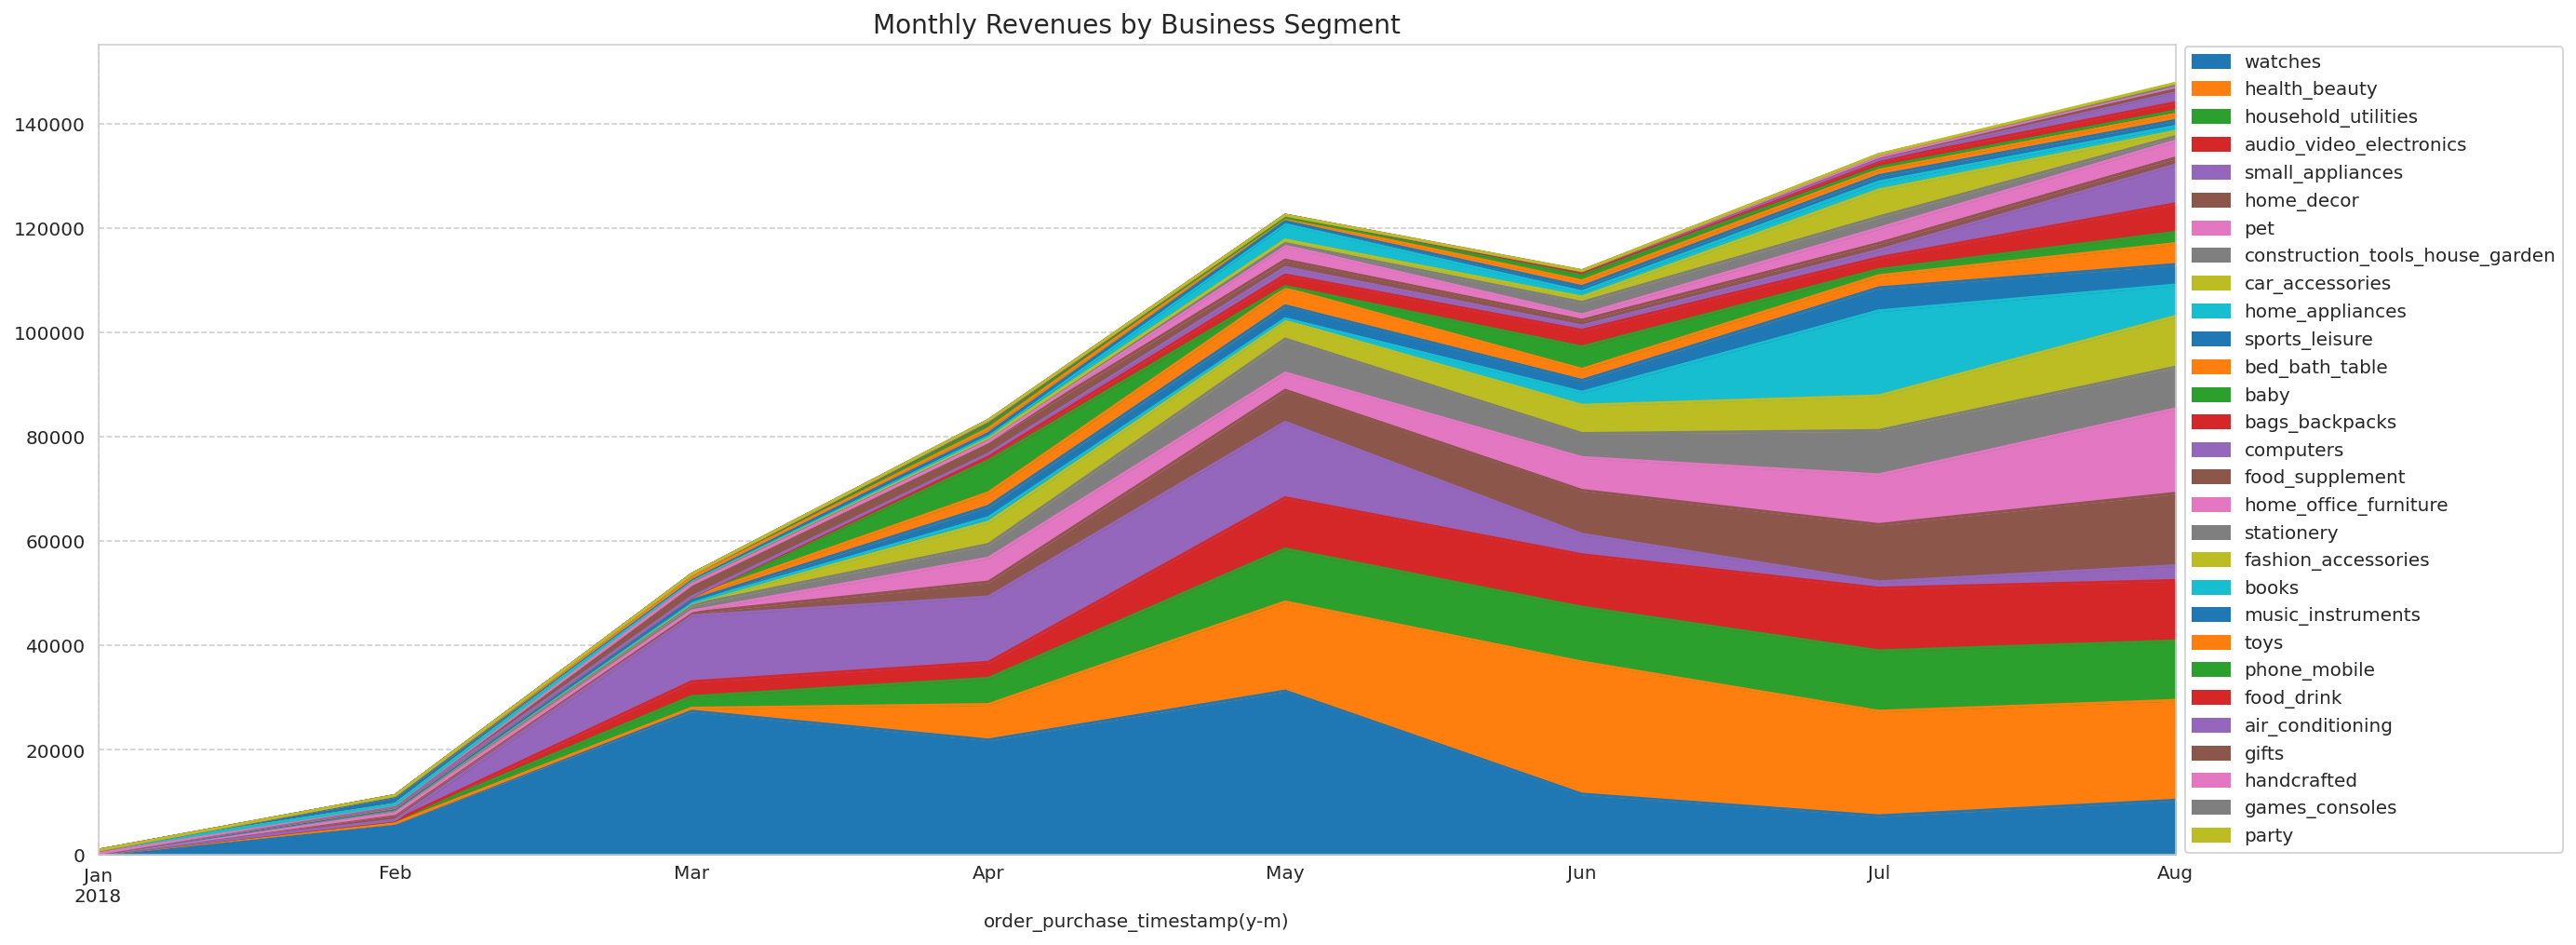

In [42]:
# Plot the monthly revenues by segment
monthly_segment_revenue.plot.area(figsize=(20,8))

plt.title('Monthly Revenues by Business Segment', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

In [43]:
# Create watches segment dataframe
watches = data[data.business_segment == 'watches']
watches.shape

(586, 36)

In [44]:
# Create monthly revenues by product category
cols = watches.groupby('product_category_name_english') \
              .price \
              .sum() \
              .sort_values(ascending=False) \
              .index

monthly_revenue_category = watches.groupby(['order_purchase_timestamp(y-m)', 'product_category_name_english']) \
                                  .price \
                                  .sum() \
                                  .unstack(level=1, fill_value=0)

monthly_revenue_category = monthly_revenue_category[cols]
monthly_revenue_category

product_category_name_english,watches_gifts,audio,electronics,sports_leisure,cool_stuff,market_place,perfumery
order_purchase_timestamp(y-m),,,,,,,
2018-02,5065.36,590.00,280.10,0.0,0.0,0.0,0.0
2018-03,19106.69,7547.76,240.00,545.0,0.0,0.0,0.0
2018-04,15588.14,5609.89,719.97,0.0,0.0,0.0,0.0
2018-05,29070.81,2216.00,0.00,0.0,0.0,0.0,0.0
2018-06,9727.88,1172.00,0.00,468.0,180.0,0.0,0.0
2018-07,5747.44,876.00,370.00,0.0,180.0,0.0,220.0
2018-08,8077.86,550.00,1464.58,0.0,0.0,287.6,0.0


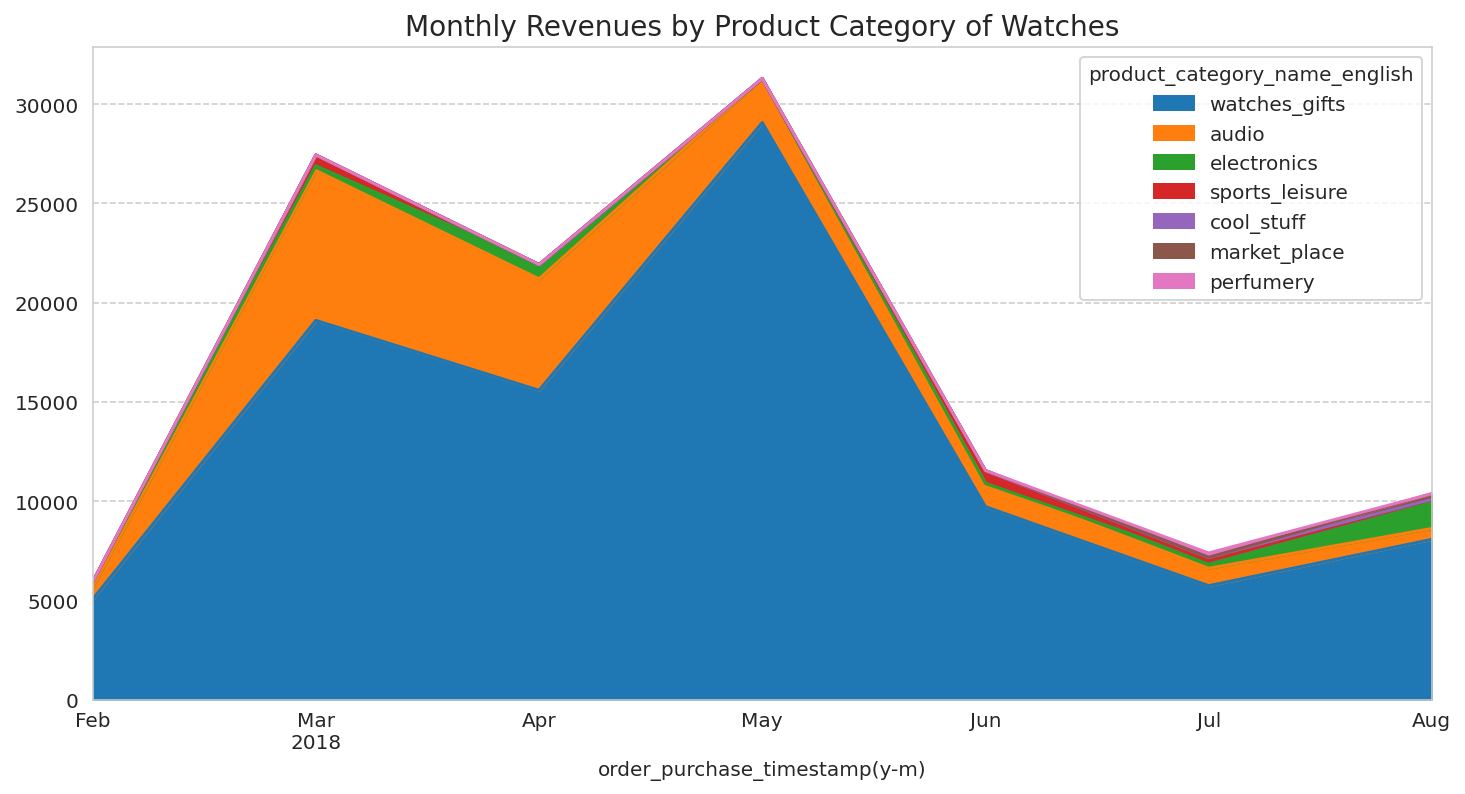

In [45]:
# Plot the monthly revenues by category
monthly_revenue_category.plot.area(figsize=(12,6))
plt.title('Monthly Revenues by Product Category of Watches', fontsize=14);

In [46]:
# Create 'seller - product category' table
cols = watches.groupby('product_category_name_english') \
              .price \
              .sum() \
              .sort_values(ascending=False) \
              .index

watches_seller_revenue = watches.groupby(['seller_id', 'product_category_name_english']) \
                                .price \
                                .sum() \
                                .unstack(level=1, fill_value=0)

watches_seller_revenue = watches_seller_revenue[cols]
watches_seller_revenue['total'] = watches_seller_revenue.sum(axis=1)

watches_seller_revenue

product_category_name_english,watches_gifts,audio,electronics,sports_leisure,cool_stuff,market_place,perfumery,total
seller_id,,,,,,,,
7d13fca15225358621be4086e1eb0964,88919.28,18561.65,3074.65,1013.0,360.0,287.6,220.0,112436.18
bce6a5ecf98e99fd2a8868b15c51f04b,3464.90,0.00,0.00,0.0,0.0,0.0,0.0,3464.90


In [47]:
# Create 'category - seller' table
index = watches.groupby('product_category_name_english') \
               .price \
               .sum() \
               .sort_values() \
               .index

seller_category_revenue = watches.groupby(['seller_id', 'product_category_name_english']) \
                                 .price \
                                 .sum() \
                                 .unstack(level=0, fill_value=0) \
                                 
seller_category_revenue = seller_category_revenue.reindex(index)
seller_category_revenue

seller_id,7d13fca15225358621be4086e1eb0964,bce6a5ecf98e99fd2a8868b15c51f04b
product_category_name_english,,
perfumery,220.00,0.0
market_place,287.60,0.0
cool_stuff,360.00,0.0
sports_leisure,1013.00,0.0
electronics,3074.65,0.0
audio,18561.65,0.0
watches_gifts,88919.28,3464.9


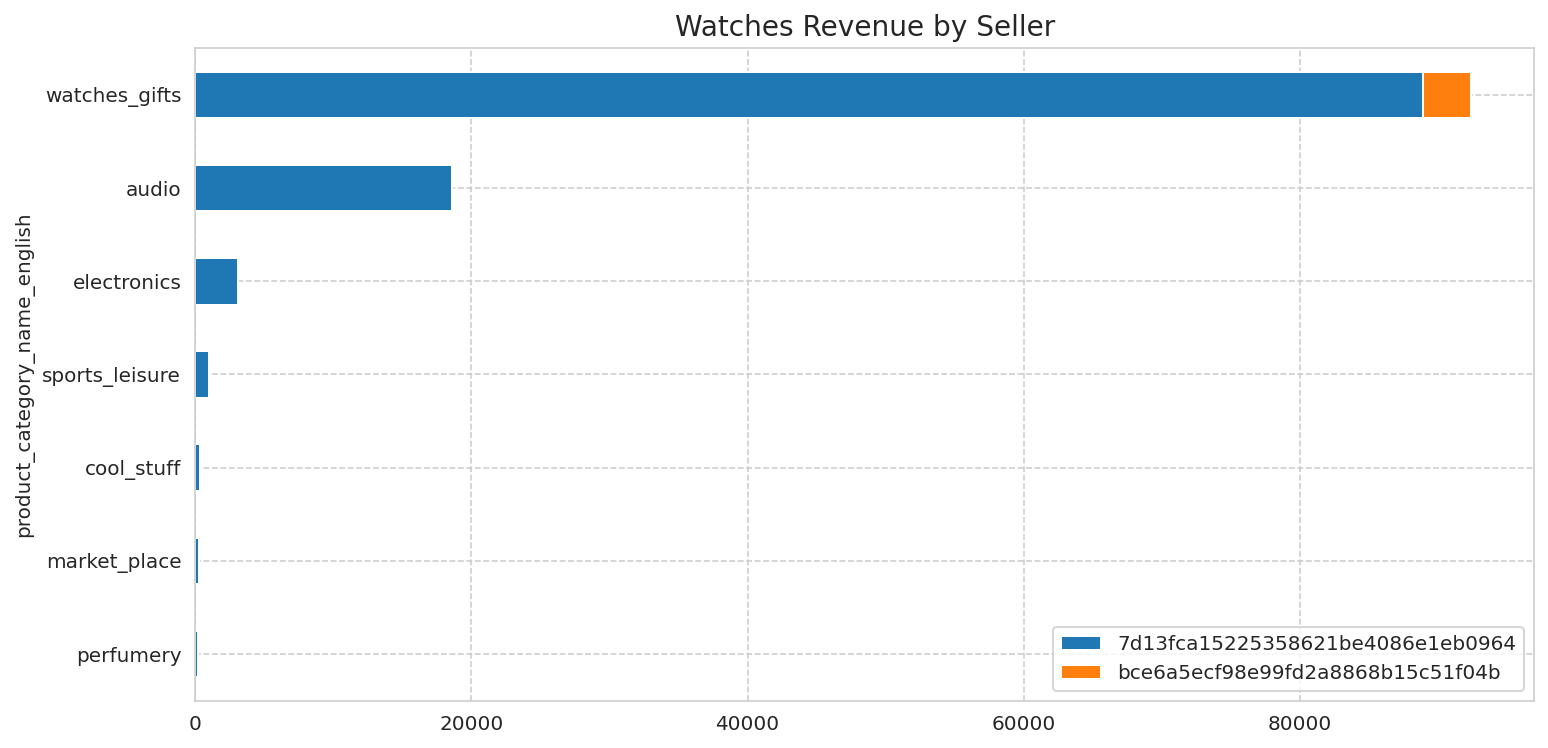

In [48]:
# Plot the above table
seller_category_revenue.plot.barh(stacked=True, figsize=(12,6))

plt.title('Watches Revenue by Seller', fontsize=14)
plt.legend(loc='lower right');

In [49]:
# Create seller info table
seller_ids = watches.groupby('seller_id').price.sum().index
fields = ['seller_id', 'won_date', 'business_segment', 'lead_type','business_type',]

data.loc[data['seller_id'].isin(seller_ids), fields] \
    .drop_duplicates(subset='seller_id', keep='first')

,seller_id,won_date,business_segment,lead_type,business_type
193,7d13fca15225358621be4086e1eb0964,2018-02-08 17:20:14,watches,online_big,reseller
420,bce6a5ecf98e99fd2a8868b15c51f04b,2018-04-13 03:00:00,watches,online_medium,reseller


In [50]:
index = watches[watches['product_category_name_english'] == 'watches_gifts'] \
                .groupby('product_id') \
                .price \
                .sum() \
                .sort_values(ascending=False) \
                .index

product_seller_revenue = watches[watches['product_category_name_english'] == 'watches_gifts'] \
                                  .groupby(['seller_id', 'product_id']) \
                                  .price \
                                  .sum() \
                                  .unstack(level=0, fill_value=0)

product_seller_revenue = product_seller_revenue.reindex(index)
product_seller_revenue.head(3)

seller_id,7d13fca15225358621be4086e1eb0964,bce6a5ecf98e99fd2a8868b15c51f04b
product_id,,
53b36df67ebb7c41585e8d54d6772e08,22574.43,0.0
1a080577618e7fe4d9ddd8fb2b47a964,8567.99,0.0
6f3b5b605d91b7439c5e3f5a8dffeea7,6970.00,0.0


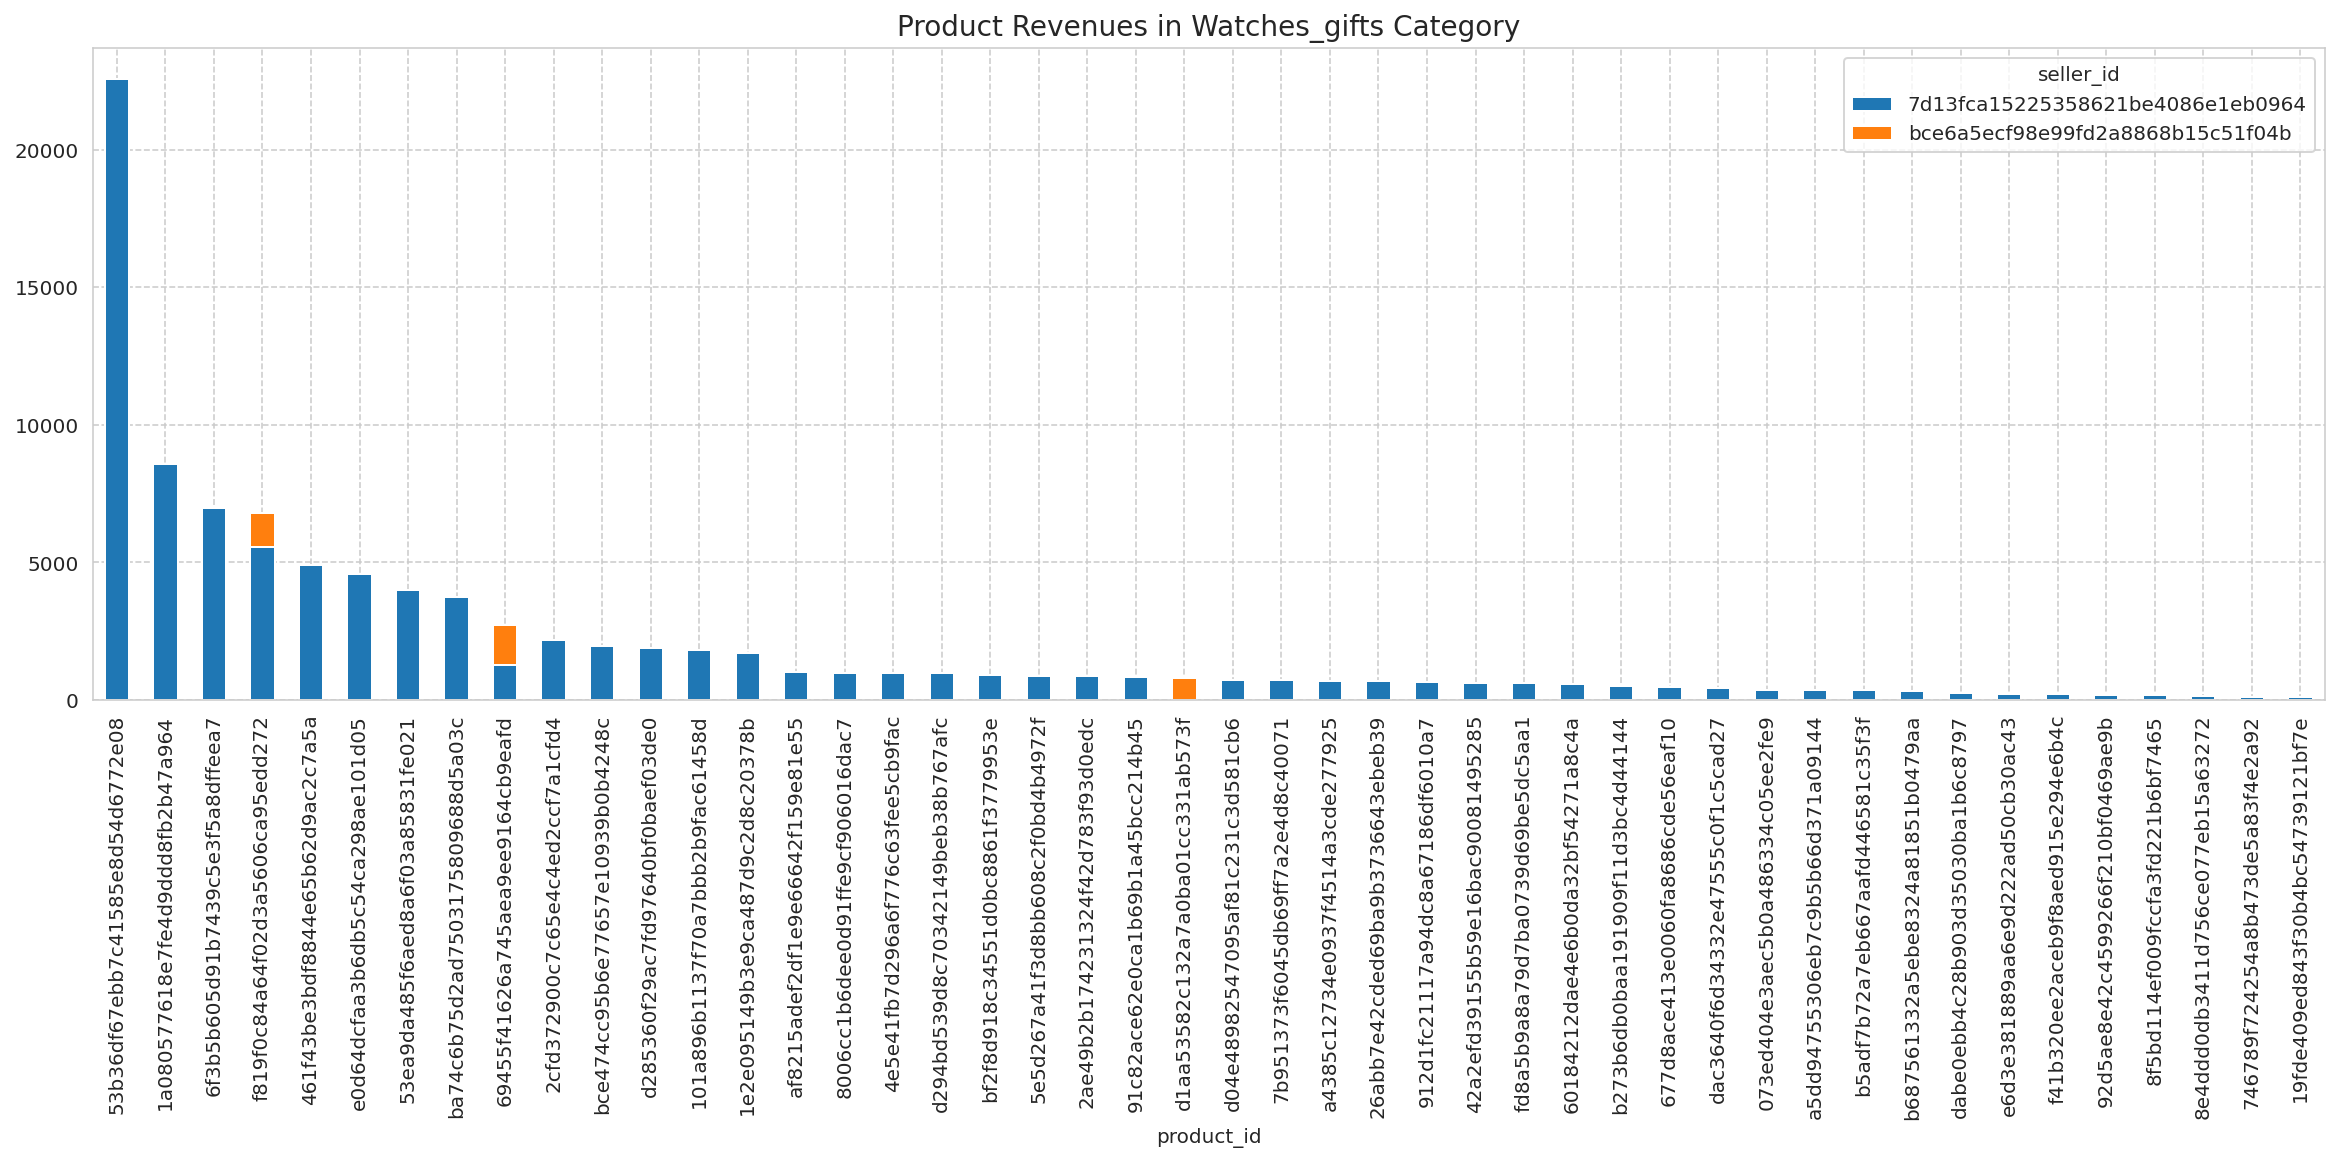

In [51]:
product_seller_revenue.plot.bar(stacked=True, figsize=(20, 6))
plt.title('Product Revenues in Watches_gifts Category', fontsize=14);

In [56]:
da=products
#da = pd.merge(da, product_translation,
#                how='left', on='product_category_name')
#da=da[['product_category_name_english','product_length_cm','product_height_cm','product_weight_g','product_width_cm']]
#da = da.append({'product_category_name_english': 'sports_watch'}, ignore_index=True)
#da = da.append({'product_category_name_english': 'cool_electronic'}, ignore_index=True)
da['conversion']=1
da.shape

(32951, 10)

In [57]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0,32951):
  review = re.sub('[^a-zA-Z]', ' ', str(da['product_category_name'][i]))
  review = review.lower()
  review = review.split()
  ps = PorterStemmer()
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [58]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = da.iloc[:, -1].values
X.shape

(32951, 106)

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [60]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
classifier = OneClassSVM(gamma='scale', nu=0.01)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
cm=confusion_matrix(y_test,y_pred)
cm

array([[   0,    0],
       [1833, 4758]])

In [61]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
classifier = IsolationForest(contamination=0.1, behaviour='new')
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
cm=confusion_matrix(y_test,y_pred)
cm

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


array([[   0,    0],
       [ 517, 6074]])

In [62]:
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import confusion_matrix
classifier = EllipticEnvelope(contamination=0.01)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
cm=confusion_matrix(y_test,y_pred)
cm

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


array([[   0,    0],
       [  46, 6545]])

In [63]:
from numpy import vstack
from sklearn.neighbors import LocalOutlierFactor
def lof_predict(model, trainX, testX):
	# create one large dataset
	composite = vstack((trainX, testX))
	# make prediction on composite dataset
	yhat = model.fit_predict(composite)
	# return just the predictions on the test set
	return yhat[len(trainX):]

classifier = LocalOutlierFactor(contamination=0.01)
classifier.fit(X_train,y_train)
y_pred = lof_predict(classifier, X_train,X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
cm=confusion_matrix(y_test,y_pred)
cm

array([[   0,    0],
       [  24, 6567]])

In [64]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
cm=confusion_matrix(y_test,y_pred)
cm

array([[6591]])